In [1]:
# import main
# import lasio
# model_path = "..\\tasks\\task 6\\Data\\modelling\\"
# main.create_csv_from_las_modeling(model_path,'modeling_aps.csv')pd.datetime.strptime(x, '%Y.%m.%d')

In [2]:
import numpy as np
import pandas as pd
import main
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
water_content_data = water_content_data.rename(columns={'date_start': 'DATE_START_WC'})
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data['DATE_START_WC'] = pd.to_datetime(water_content_data['DATE_START_WC'])
water_content_data.head(n=5)

,WELL_NAME,DATE_START_WC,WC
0,380,1905-04-07,0.49
1,379,2006-01-12,0.30
2,370,2007-01-02,0.13
3,417,2007-01-03,0.08
4,389,2007-01-08,0.22


In [3]:
well_name_keys = pd.read_csv(main.data_dir + '\\well_name_key.csv' , delimiter=';')
well_name_keys.replace('314_', '', regex=True, inplace=True)
#del las_data['well_name']
well_name_keys = well_name_keys.rename(columns={'well_name': 'WELL_NAME'})
well_name_keys = well_name_keys.rename(columns={'well_name_uwi': 'WELL_NAME_UWI'})
well_name_keys['WELL_NAME'] = well_name_keys['WELL_NAME'].astype('str')
well_name_keys['WELL_NAME_UWI'] = well_name_keys['WELL_NAME_UWI'].astype('str')
well_name_keys.head(n=2)

,WELL_NAME,WELL_NAME_UWI
0,224st4,103ST2
1,238st4,117ST2


In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
perf_data = pd.read_csv(main.data_dir + '\\perforation_wellname.csv' , delimiter=';', date_parser=dateparse)
del perf_data['Пласт']
del perf_data['ГИС']
del perf_data['Тип']
del perf_data['Перфоратор']
del perf_data['N отв']
del perf_data['Hнач(abs,тр)']
del perf_data['Hкон(abs,тр)']
del perf_data['Hнач(abs)']
del perf_data['Hкон(abs)']
del perf_data['Плотность']
del perf_data['Открыт']
perf_data = perf_data.rename(columns={'Скважина': 'WELL_NAME'})
perf_data = perf_data.rename(columns={'Дата': 'PERF_DATE'})
perf_data = perf_data.rename(columns={'Hнач(md)':'DEPTH_TOP'})
perf_data = perf_data.rename(columns={'Hкон(md)':'DEPTH_BOTTOM'})
perf_data['PERF_DATE'] = pd.to_datetime(perf_data['PERF_DATE'])
perf_data.head(n=2)

,WELL_NAME,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,312,2013-06-28,2671.0,2687.0
1,313,2014-10-06,3123.0,3133.0


In [5]:
merge_data = pd.merge(water_content_data, perf_data, on='WELL_NAME')
merge_data.head()
print(merge_data.count())
merge_data.head(n=2)

WELL_NAME        327
DATE_START_WC    327
WC               327
PERF_DATE        327
DEPTH_TOP        327
DEPTH_BOTTOM     327
dtype: int64


,WELL_NAME,DATE_START_WC,WC,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,380,1905-04-07,0.49,2012-05-31,2720.0,2733.0
1,379,2006-01-12,0.30,2006-10-22,2756.0,2770.0


In [6]:
merge_data['DIFF'] = (merge_data['DATE_START_WC'] - merge_data['PERF_DATE']).dt.days
perf_data_wc = merge_data[merge_data['DIFF'] > -90]
print(len(perf_data_wc))

64


Проверка на расчитанных данных

In [7]:
well_name_list = perf_data_wc['WELL_NAME'].value_counts().index.tolist()
for name in well_name_list:
    temp_data = perf_data_wc[perf_data_wc['WELL_NAME'] == name]
    if(len(temp_data['WELL_NAME'].value_counts().index.tolist()) > 1):
        perf_data_wc = perf_data_wc[perf_data_wc['WELL_NAME'] != name]

In [8]:
len(perf_data_wc['WELL_NAME'].value_counts().index.tolist())

58

Проверка на данных ГИС

In [9]:
las_out_file_name = 'AllGisParams\\fake_gis_las_all_out.csv'
global_data = pd.read_csv(las_out_file_name, delimiter=';')
global_data['WELL_NAME'] = global_data['WELL_NAME'].astype('str')
global_data['WELL_NAME_UWI'] = global_data['WELL_NAME_UWI'].astype('str')

In [10]:
params_name = ['CILD']
all_params = ['WELL_NAME', 'WELL_NAME_UWI', 'DEPT']
all_params.extend(params_name)
las_data = global_data[all_params].copy()
las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
las_data.head(n=5)
# Объединяем данные
real_data = pd.merge(las_data, perf_data_wc, on='WELL_NAME')
real_data_na = real_data.dropna()

# очистка данных
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
real_data_na = real_data_na[(real_data_na['CILD'] >= 0) & (real_data_na['CILD'] < 250)]
print('real, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())
real_data_na[params_name] = scaler.fit_transform(real_data_na[params_name])
print('scaler, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())

real, min =  CILD    0.0
dtype: float64  max =  CILD    249.6
dtype: float64
scaler, min =  CILD    0.0
dtype: float64  max =  CILD    1.0
dtype: float64


In [11]:
# объединение данных по всем параметрам
min_count_val_in_data = 10
count_val = 100
print('Start union table')

print(len(real_data['WELL_NAME'].value_counts()))
# Преобразуем в данные для обучения
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()

x_values = []
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
for param in params_name:
    params_name_file = (param.replace(':','')).lower()
    print('Convert ', param, 'start')

#     [x_values_temp, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                            min_count_val_in_data)
    [x_values_temp, y_values, y_names] = main.ConvertDataToLearningPerforation(real_data_na, param, 
                                                               min_count_val_in_data, count_val)
    if (len(x_values) > 0):
        for src, res in zip(x_values_temp, x_values):
            res.extend(src)
            #print('res = ',len(res), 'src = ', len(src))
    else:
        x_values = x_values_temp.copy()
                
    print('length =', len(x_values), len(y_values), len(x_values[0]))
    

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

y_values_r = y_values
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)

Start union table
53
Convert  CILD start
0  of  53


D:\NIPI\machine learning\las_ml-master\main.py:303: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data_well_by_bound.sort(['DEPT'], ascending=[False])


20  of  53
40  of  53
end ConvertDataToLearning
length = 53 53 100


D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

forest_reg =  RandomForestRegressor(n_estimators=10,
                           random_state=17)
# oob_score=True,

from sklearn.model_selection import GridSearchCV, cross_val_score
forest_params = { 
    'max_depth': [1, 10, 20, 40, 60, 100, 200, 500],
    'n_estimators': [1, 10, 30, 50, 70, 100, 150, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, n_jobs=-1, verbose=True)
value_fit = forest_grid.fit(x_train, y_train) 
y_predict = forest_grid.predict(x_hold)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   59.4s finished


Анализ реальных aps с аппроксимированными значениями wc


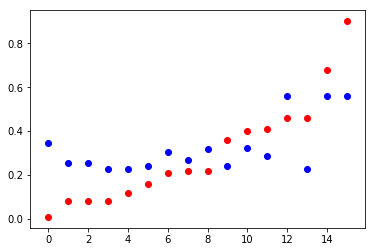

MSE                      = 0.0289834916035
MAE                      = 0.148311759373
r2_score                 = 0.475022191921    (best_value is 1)
explained_variance_score = 0.483562449704    (best_value is 1)
37


In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
y_pred = forest_grid.predict(x_hold)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_pred})
# print('Анализ реальных aps с реальными значениями wc')
print('Анализ реальных aps с аппроксимированными значениями wc')
data_analize_func(predict_for_analize_fake)
print(len(x_train))